# Comprehensive EDA: Ames Housing Prices Dataset

This notebook performs thorough Exploratory Data Analysis (EDA) for the Ames Housing Prices dataset. Each section includes visualizations and detailed guides on how to interpret the plots.


## Setup and Data Loading


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv("data/train.csv")

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of observations: {df.shape[0]}")

Dataset shape: (1460, 81)
Number of features: 80
Number of observations: 1460


---

# SECTION 1 — TARGET VARIABLE ANALYSIS

## 1. Distribution of SalePrice (Raw)


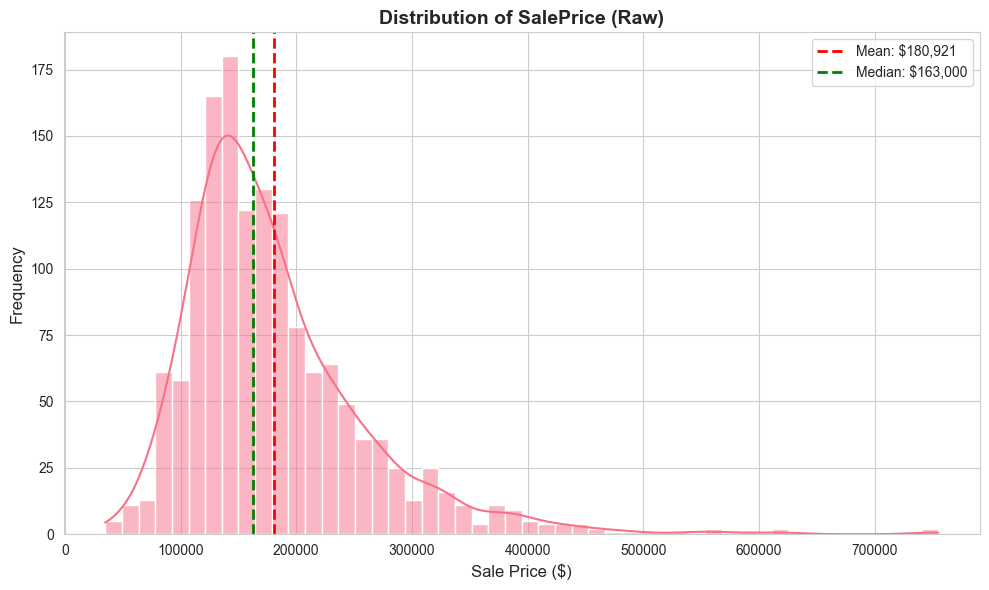


Skewness: 1.88
Mean: $180,921.20
Median: $163,000.00


In [3]:
# Create histogram with KDE for raw SalePrice
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
sns.histplot(df['SalePrice'], kde=True, bins=50, ax=ax)
ax.set_title('Distribution of SalePrice (Raw)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sale Price ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add statistics
mean_price = df['SalePrice'].mean()
median_price = df['SalePrice'].median()
ax.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_price:,.0f}')
ax.axvline(median_price, color='green', linestyle='--', linewidth=2, label=f'Median: ${median_price:,.0f}')
ax.legend()

plt.tight_layout()
plt.show()

# Calculate skewness
skewness = df['SalePrice'].skew()
print(f"\nSkewness: {skewness:.2f}")
print(f"Mean: ${mean_price:,.2f}")
print(f"Median: ${median_price:,.2f}")


From mean > median, skewness > 1, and the long tail on the right: Sale price is right skewed. This is a problem because right skewed distributions violate some assumptions of linear models (normality homoscedasticity)

Lets try a log tansformation and see if Sale Price takes a more "normal" shape


## 2. Distribution of Log(SalePrice)


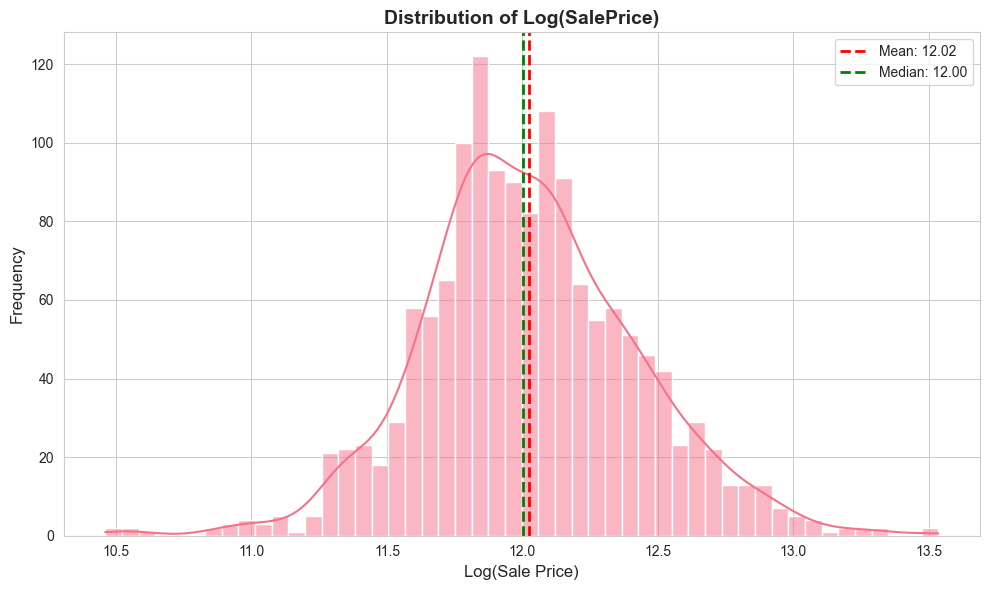


Skewness (after log transform): 0.12
Mean: 12.02
Median: 12.00


In [4]:
# Create log-transformed SalePrice
df['LogSalePrice'] = np.log1p(df['SalePrice'])

# Create histogram with KDE for log-transformed SalePrice
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['LogSalePrice'], kde=True, bins=50, ax=ax)
ax.set_title('Distribution of Log(SalePrice)', fontsize=14, fontweight='bold')
ax.set_xlabel('Log(Sale Price)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add statistics
mean_log = df['LogSalePrice'].mean()
median_log = df['LogSalePrice'].median()
ax.axvline(mean_log, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_log:.2f}')
ax.axvline(median_log, color='green', linestyle='--', linewidth=2, label=f'Median: {median_log:.2f}')
ax.legend()

plt.tight_layout()
plt.show()

# Calculate skewness after transformation
skewness_log = df['LogSalePrice'].skew()
print(f"\nSkewness (after log transform): {skewness_log:.2f}")
print(f"Mean: {mean_log:.2f}")
print(f"Median: {median_log:.2f}")


This looks much better from the eye test and also:
- mean≈median
- skewness is much smaller

When training models we should use a log transformed 

## 3. Boxplot of SalePrice


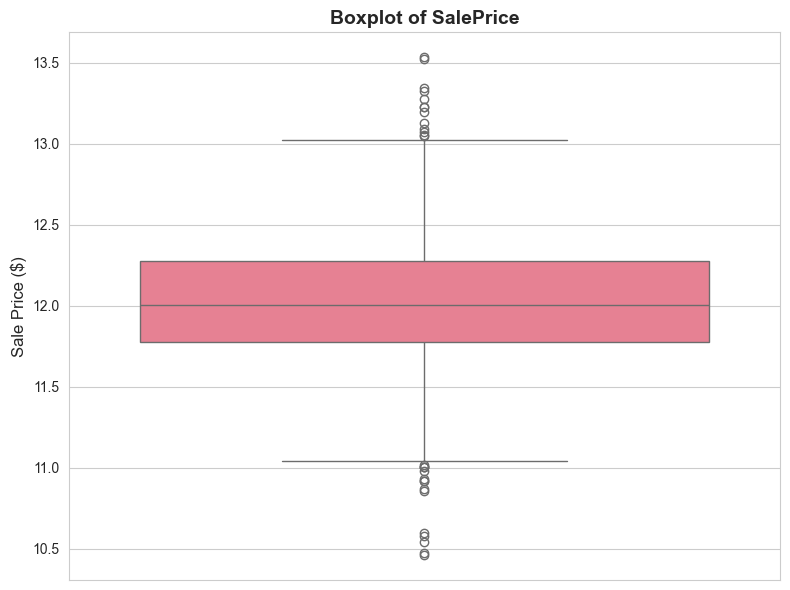


Outlier Statistics:
Q1 (25th percentile): $11.78
Q3 (75th percentile): $12.27
IQR: $0.50
Lower bound: $11.03
Upper bound: $13.02

Number of outliers: 28 (1.92%)


In [23]:
# Create boxplot for SalePrice
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(y=df['LogSalePrice'], ax=ax)
ax.set_title('Boxplot of SalePrice', fontsize=14, fontweight='bold')
ax.set_ylabel('Sale Price ($)', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate outlier statistics
Q1 = df['LogSalePrice'].quantile(0.25)
Q3 = df['LogSalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['LogSalePrice'] < lower_bound) | (df['LogSalePrice'] > upper_bound)]
print(f"\nOutlier Statistics:")
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"\nNumber of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")


Seems like we have a lot of high outliers here but we shouldn't necesarily delete them because:
- our plan to use a log trasformation will make this not matter so much
- for more robust models (random forest, XGBoost) outliers don't affect performance as much

---

# SECTION 2 — MISSING VALUE EXPLORATION

## 4. Missingness Heatmap


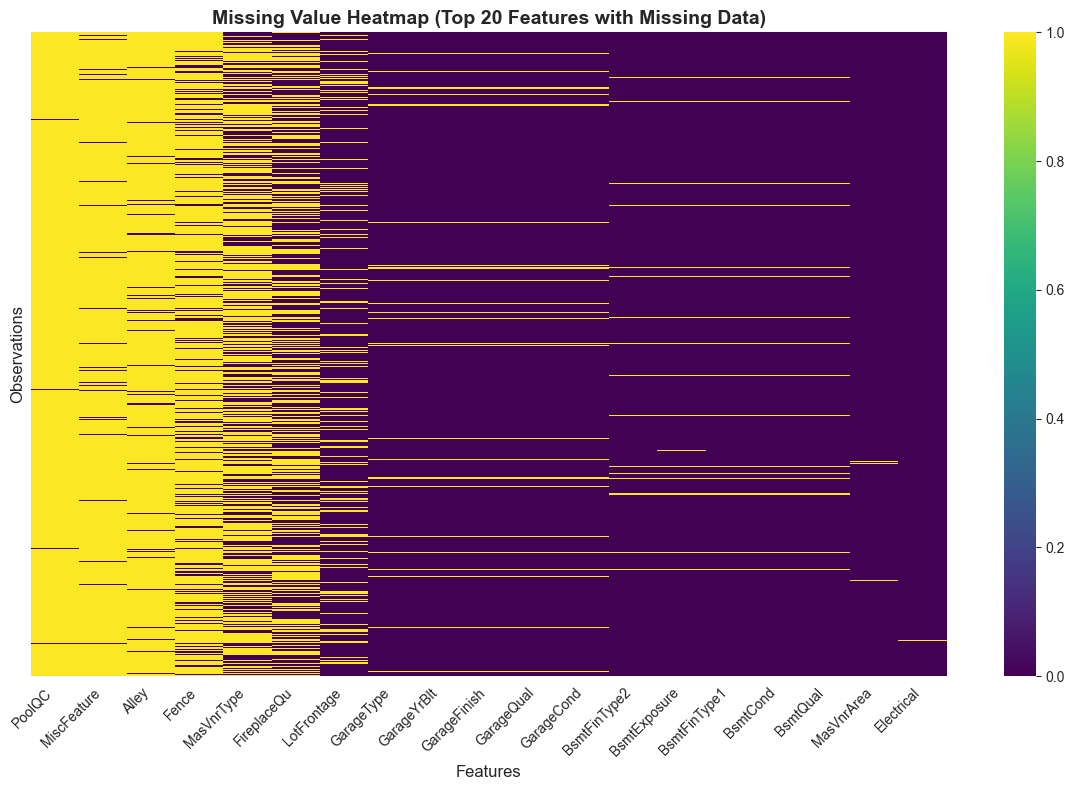


Total features with missing values: 19


In [6]:
# Calculate missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

# Create a subset of features with missing values for visualization
missing_df = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percent': missing_percent.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

# Create heatmap of missing values
# Select top 20 features with most missing values for better visualization
top_missing = missing_df.head(20)

# Create a matrix for heatmap
missing_matrix = df[top_missing['Feature'].tolist()].isnull()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(missing_matrix, yticklabels=False, cbar=True, cmap='viridis', ax=ax)
ax.set_title('Missing Value Heatmap (Top 20 Features with Missing Data)', fontsize=14, fontweight='bold')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Observations', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal features with missing values: {len(missing_df)}")


Structural NA's (usually categorical so will just have to make a None category for them):
- PoolQC
- MiscFeature
- Alley
- Fence
- MasVnrType (already encoded as None)
- FireplaceQu
- GarageType        |
- GarageFinish      |
- GarageQual        | correlated
- GarageCond        |
- BsmtFinType2  |
- BsmtExposure  |
- BsmtFinType1  | correlated
- BsmtCond      |
- BsmtQual      |

True missing (require some kind of imputation):
- LotFrontage
- GarageYrBlt
- MasVnrArea


Other:
- Electrical (no NA by structure so need to impute it somehow (probably wont matter that much though cause only one house is NA for this))


## 5. Table of Features Sorted by % Missing


Features with Missing Values (Sorted by % Missing):
Feature                   Missing Count   Missing %       Data Type      
--------------------------------------------------------------------------------
PoolQC                    1453             99.52%      object         
MiscFeature               1406             96.30%      object         
Alley                     1369             93.77%      object         
Fence                     1179             80.75%      object         
MasVnrType                872              59.73%      object         
FireplaceQu               690              47.26%      object         
LotFrontage               259              17.74%      float64        
GarageType                81                5.55%      object         
GarageYrBlt               81                5.55%      float64        
GarageFinish              81                5.55%      object         
GarageQual                81                5.55%      object         
GarageCond  

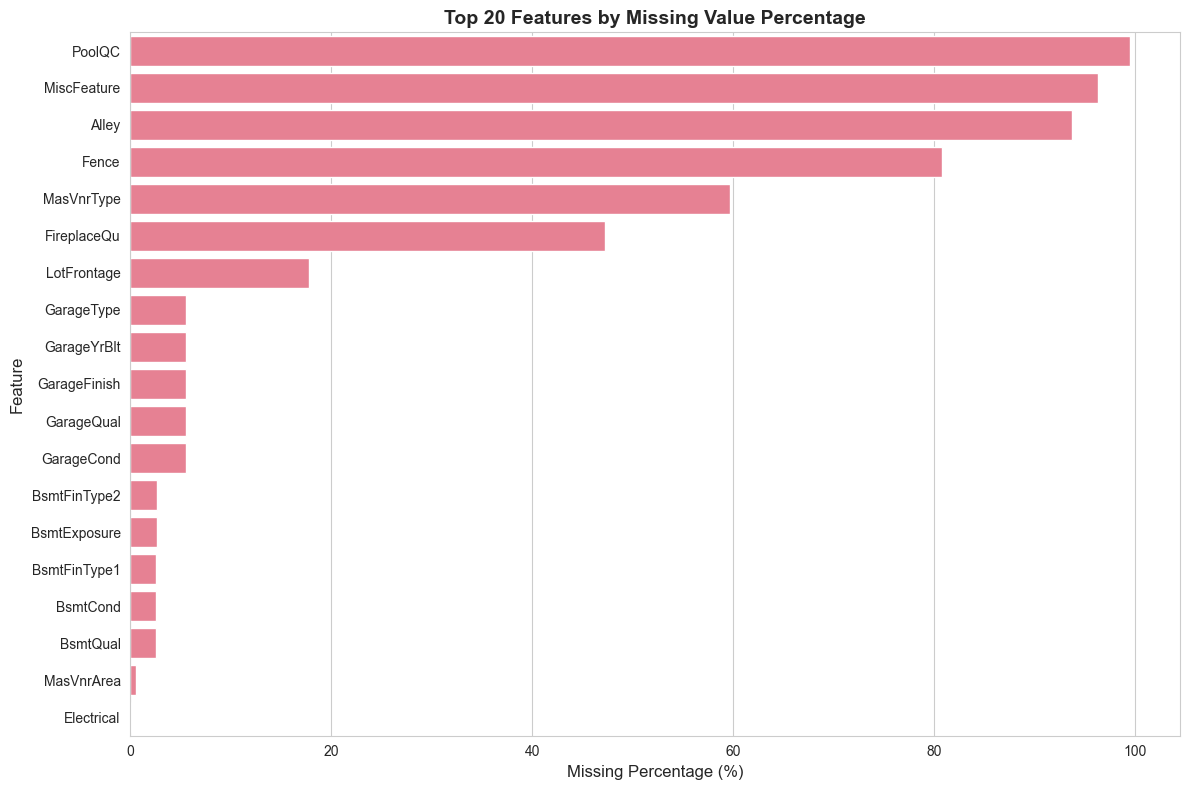

In [7]:
# Create comprehensive missing value table
missing_table = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percent': missing_percent.values,
    'Data Type': df.dtypes.values
})
missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values('Missing Percent', ascending=False)

# Display formatted table
print("Features with Missing Values (Sorted by % Missing):")
print("=" * 80)
print(f"{'Feature':<25} {'Missing Count':<15} {'Missing %':<15} {'Data Type':<15}")
print("-" * 80)
for idx, row in missing_table.iterrows():
    print(f"{row['Feature']:<25} {int(row['Missing Count']):<15} {row['Missing Percent']:>6.2f}%      {str(row['Data Type']):<15}")

# Visualize missing percentages
fig, ax = plt.subplots(figsize=(12, 8))
top_20_missing = missing_table.head(20)
sns.barplot(data=top_20_missing, y='Feature', x='Missing Percent', ax=ax)
ax.set_title('Top 20 Features by Missing Value Percentage', fontsize=14, fontweight='bold')
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()


How should we deal with:
PoolQC:         Encode None
MiscFeature     Encode None  
Alley           Encode None     
Fence           Encode None
MasVnrType      Keep the same (already encoded as None)  
FireplaceQu     Encode None   
LotFrontage     Impute with median
GarageType      Encode None  
GarageYrBlt     Impute with 0
GarageFinish    Encode None
GarageQual      Encode None
GarageCond      Encode None  
BsmtFinType2    Encode None    
BsmtExposure    Encode None  
BsmtFinType1    Encode None     
BsmtCond        Encode None
BsmtQual        Encode None
MasVnrArea      Encode None
Electrical      Impute with mode

In [ ]:
# Handle missing values according to the plan above

# Create a copy to avoid modifying the original dataframe
df_processed = df.copy()

print("Handling Missing Values:")
print("=" * 60)

# 1. Encode None for categorical variables with structural NAs
none_encode_vars = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
    'MasVnrType', 'MasVnrArea'
]

for var in none_encode_vars:
    if var in df_processed.columns:
        missing_count = df_processed[var].isnull().sum()
        if missing_count > 0:
            # For object (categorical) columns, fill with 'None'
            if df_processed[var].dtype == 'object':
                df_processed[var] = df_processed[var].fillna('None')
                print(f"✓ {var:<20} Encoded {missing_count:>4} NAs as 'None' (categorical)")
            # For numeric columns (like MasVnrArea), fill with 0
            else:
                df_processed[var] = df_processed[var].fillna(0)
                print(f"✓ {var:<20} Encoded {missing_count:>4} NAs as 0 (numerical)")

# 2. Impute LotFrontage with median
if 'LotFrontage' in df_processed.columns:
    missing_count = df_processed['LotFrontage'].isnull().sum()
    if missing_count > 0:
        median_lotfrontage = df_processed['LotFrontage'].median()
        df_processed['LotFrontage'] = df_processed['LotFrontage'].fillna(median_lotfrontage)
        print(f"✓ LotFrontage         Imputed {missing_count:>4} NAs with median: {median_lotfrontage:.1f}")

# 3. Impute GarageYrBlt with 0
if 'GarageYrBlt' in df_processed.columns:
    missing_count = df_processed['GarageYrBlt'].isnull().sum()
    if missing_count > 0:
        df_processed['GarageYrBlt'] = df_processed['GarageYrBlt'].fillna(0)
        print(f"✓ GarageYrBlt         Imputed {missing_count:>4} NAs with 0")

# 4. Impute Electrical with mode
if 'Electrical' in df_processed.columns:
    missing_count = df_processed['Electrical'].isnull().sum()
    if missing_count > 0:
        mode_electrical = df_processed['Electrical'].mode()[0] if len(df_processed['Electrical'].mode()) > 0 else 'SBrkr'
        df_processed['Electrical'] = df_processed['Electrical'].fillna(mode_electrical)
        print(f"✓ Electrical         Imputed {missing_count:>4} NAs with mode: {mode_electrical}")

# Update the main dataframe
df = df_processed.copy()

print("\n" + "=" * 60)
print("Missing value handling complete!")
print(f"Remaining missing values: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    print("\nFeatures with remaining missing values:")
    remaining_missing = df.isnull().sum()[df.isnull().sum() > 0]
    for var, count in remaining_missing.items():
        print(f"  {var}: {count}")


---

# SECTION 3 — NUMERICAL FEATURES (UNIVARIATE)

## 6. Distribution Plots for Numerical Features


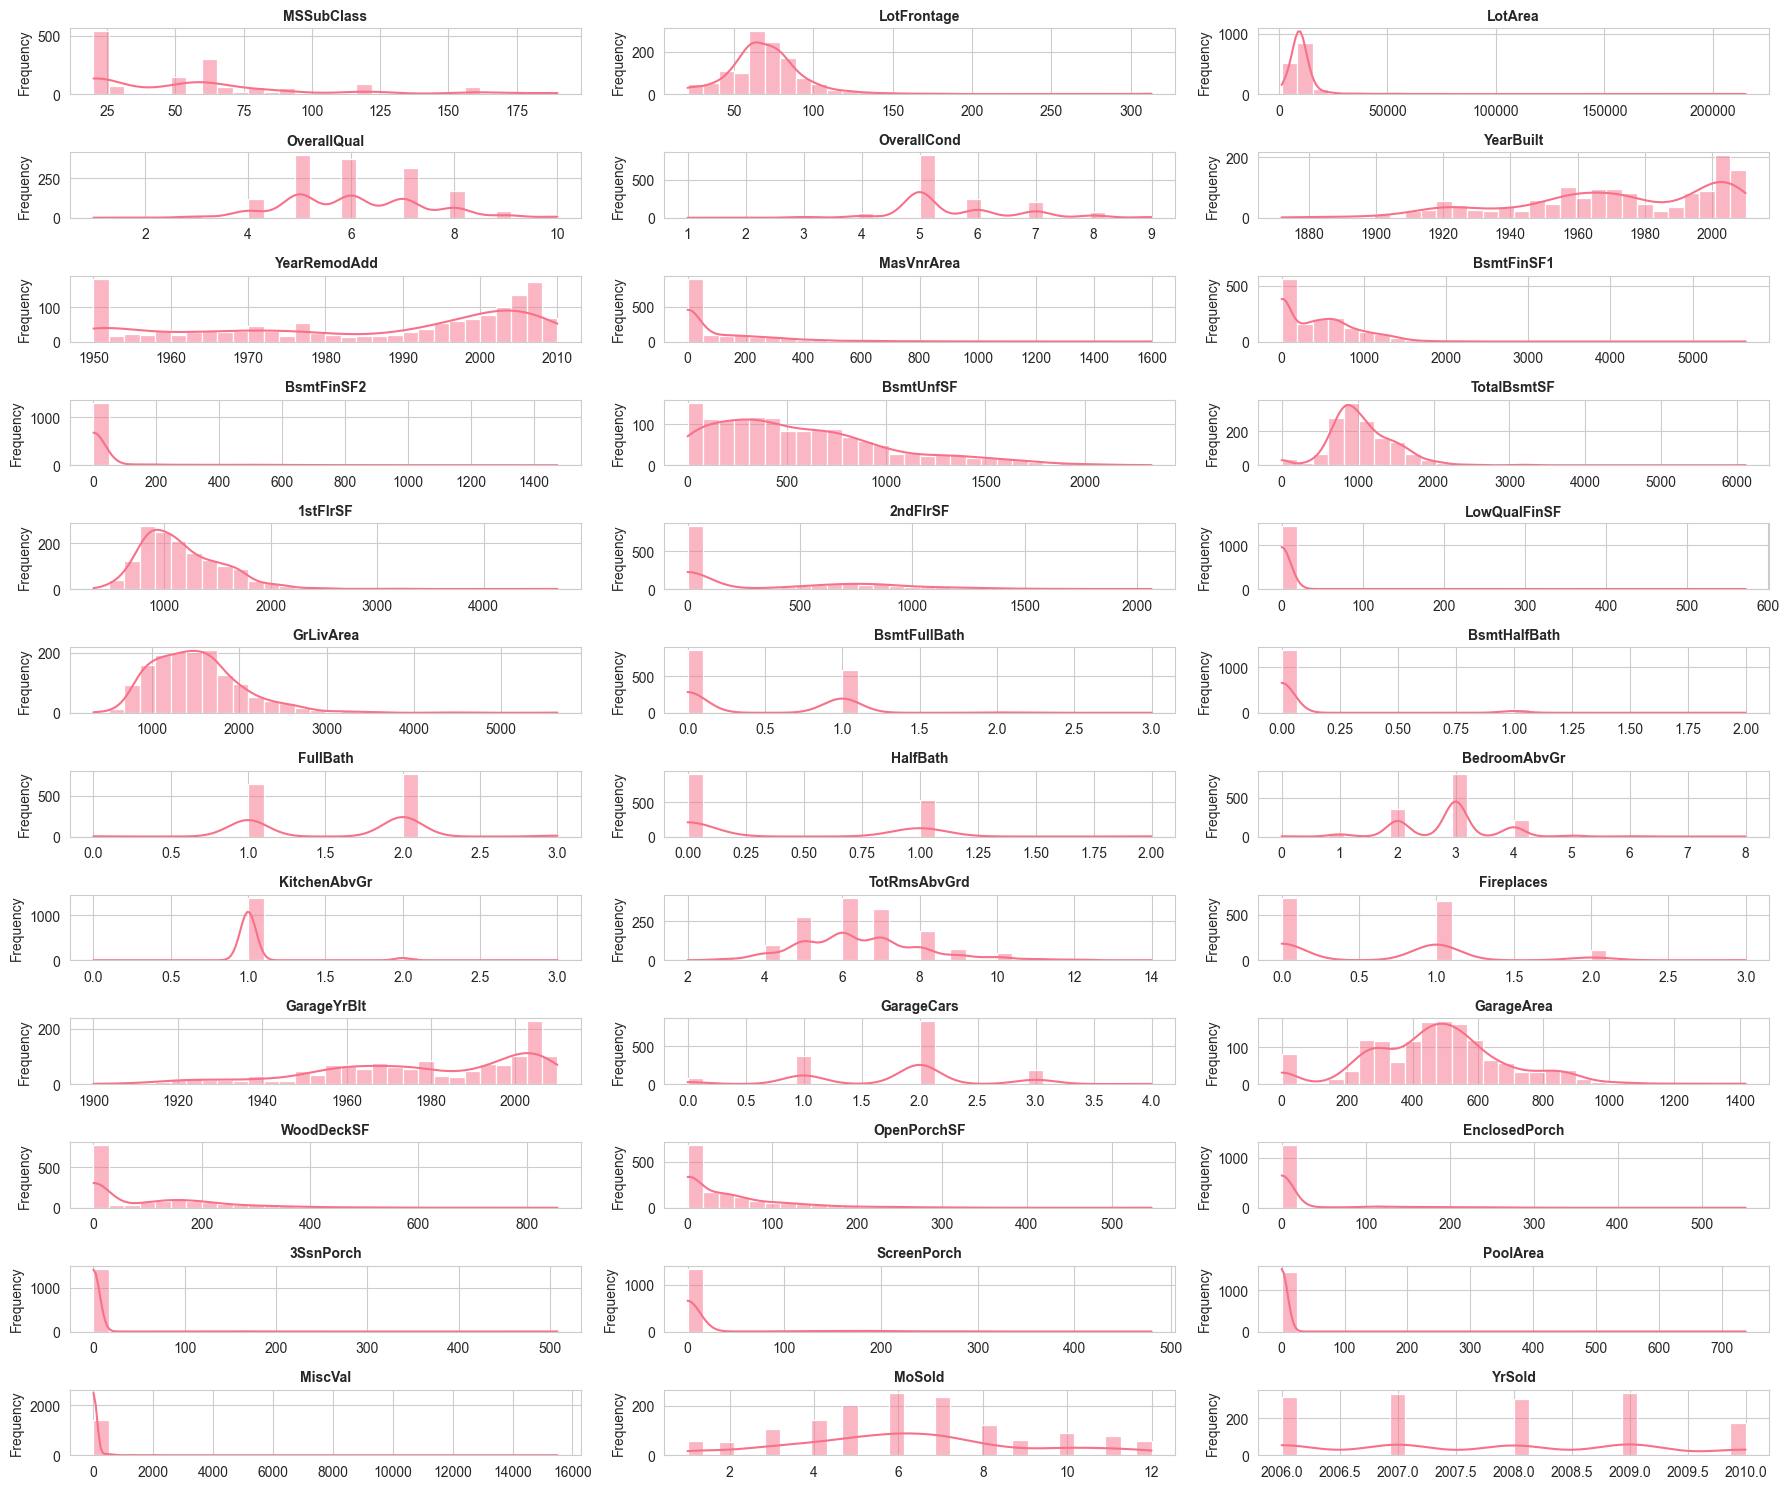


Skewness Analysis Numerical Features:
MSSubClass           Skewness:    1.41
LotFrontage          Skewness:    2.16
LotArea              Skewness:   12.21
OverallQual          Skewness:    0.22
OverallCond          Skewness:    0.69
YearBuilt            Skewness:   -0.61
YearRemodAdd         Skewness:   -0.50
MasVnrArea           Skewness:    2.67
BsmtFinSF1           Skewness:    1.69
BsmtFinSF2           Skewness:    4.26
BsmtUnfSF            Skewness:    0.92
TotalBsmtSF          Skewness:    1.52
1stFlrSF             Skewness:    1.38
2ndFlrSF             Skewness:    0.81
LowQualFinSF         Skewness:    9.01
GrLivArea            Skewness:    1.37
BsmtFullBath         Skewness:    0.60
BsmtHalfBath         Skewness:    4.10
FullBath             Skewness:    0.04
HalfBath             Skewness:    0.68
BedroomAbvGr         Skewness:    0.21
KitchenAbvGr         Skewness:    4.49
TotRmsAbvGrd         Skewness:    0.68
Fireplaces           Skewness:    0.65
GarageYrBlt          Skew

In [12]:
# Helper function to plot distributions
def plot_numeric_distributions(df, numeric_cols, n_cols=3, figsize=(15, 12)):
    """Plot histograms with KDE for numerical features"""
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[idx])
            axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
            axes[idx].set_xlabel('')
            axes[idx].set_ylabel('Frequency')
    
    # Hide extra subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Select key numerical features (excluding Id and SalePrice)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Id', 'SalePrice', 'LogSalePrice']]

plot_numeric_distributions(df, numeric_cols, n_cols=3, figsize=(18, 15))

# Calculate skewness for key features
print("\nSkewness Analysis Numerical Features:")
print("=" * 60)
for col in numeric_cols:
    if col in df.columns:
        skew_val = df[col].skew()
        print(f"{col:<20} Skewness: {skew_val:>7.2f}")


### 📊 How to Analyze These Plots:

**Detecting Skewed Variables:**
- **Right skew**: Distribution has a long tail to the right (most values on left, few high values)
- **Left skew**: Distribution has a long tail to the left
- **Symmetric**: Bell-shaped, normal distribution

**Heavy Right Tails Requiring Log Transform:**
- **Skewness > 1**: Strong right skew, consider log transformation
- **Skewness > 2**: Very strong skew, log transform highly recommended
- **Common candidates**: LotArea, GrLivArea, TotalBsmtSF, GarageArea (area/size features)

**Suspicious Multimodal Patterns:**
- **Multiple peaks**: May indicate different property types or subpopulations
- **Bimodal distribution**: Could suggest two distinct groups (e.g., old vs new houses)
- **Action**: Consider creating categorical features or separate models for different modes

**Transformation Strategy:**
- **Log transform**: For right-skewed area/size features (LotArea, GrLivArea, etc.)
- **Square root**: Alternative for less severe skewness
- **Box-Cox**: Advanced transformation for optimal normalization


## 7. Boxplots for Numerical Features


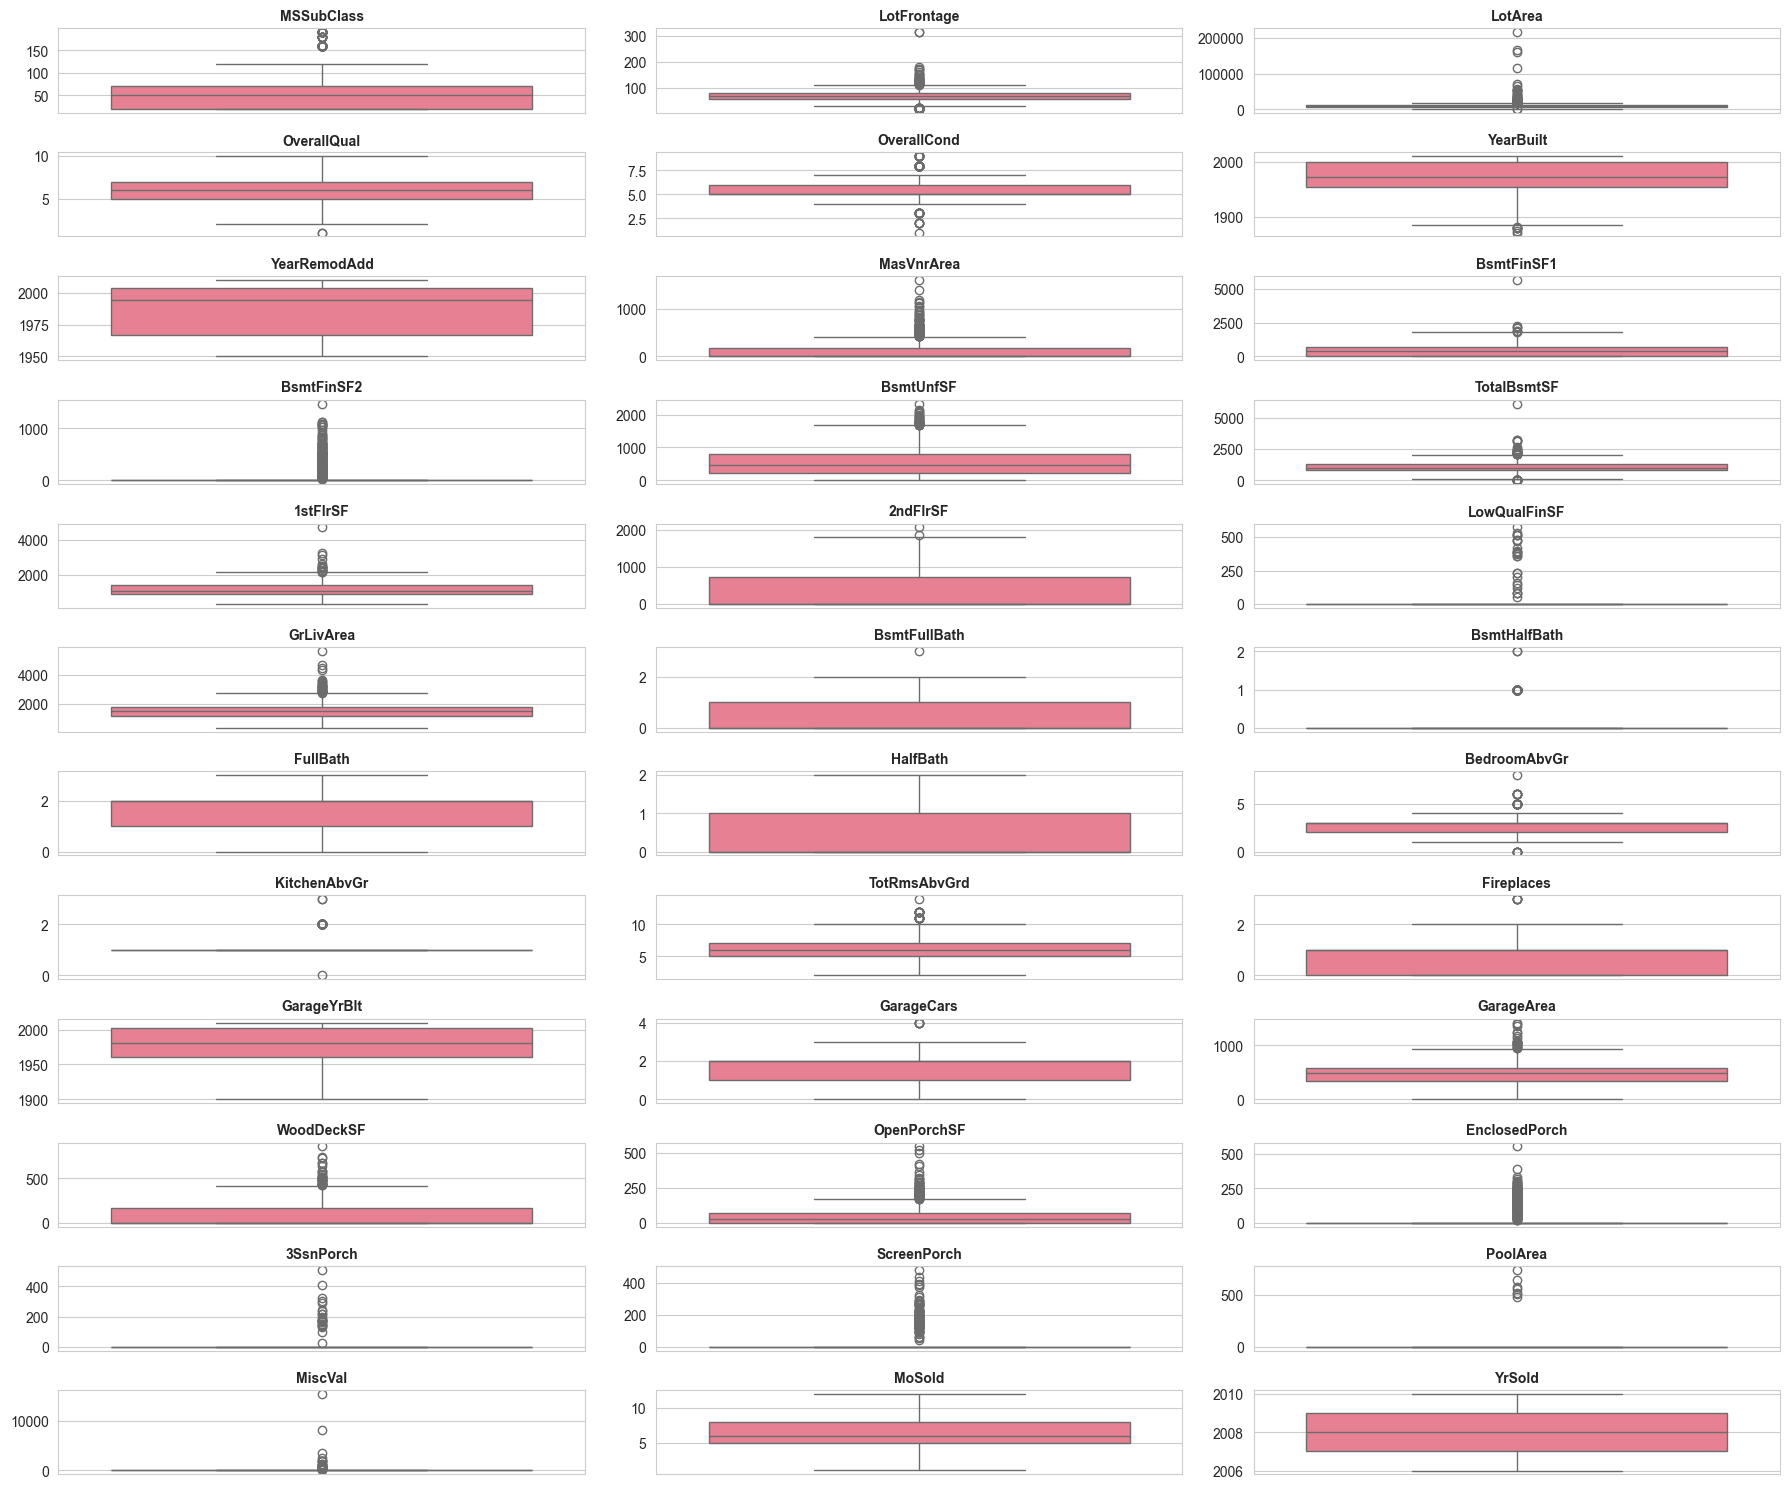


Potential Outliers (values beyond 1.5×IQR):
MSSubClass           Outliers:  103 ( 7.05%)
LotFrontage          Outliers:   88 ( 6.03%)
LotArea              Outliers:   69 ( 4.73%)
OverallQual          Outliers:    2 ( 0.14%)
OverallCond          Outliers:  125 ( 8.56%)
YearBuilt            Outliers:    7 ( 0.48%)
MasVnrArea           Outliers:   96 ( 6.58%)
BsmtFinSF1           Outliers:    7 ( 0.48%)
BsmtFinSF2           Outliers:  167 (11.44%)
BsmtUnfSF            Outliers:   29 ( 1.99%)
TotalBsmtSF          Outliers:   61 ( 4.18%)
1stFlrSF             Outliers:   20 ( 1.37%)
2ndFlrSF             Outliers:    2 ( 0.14%)
LowQualFinSF         Outliers:   26 ( 1.78%)
GrLivArea            Outliers:   31 ( 2.12%)
BsmtFullBath         Outliers:    1 ( 0.07%)
BsmtHalfBath         Outliers:   82 ( 5.62%)
BedroomAbvGr         Outliers:   35 ( 2.40%)
KitchenAbvGr         Outliers:   68 ( 4.66%)
TotRmsAbvGrd         Outliers:   30 ( 2.05%)
Fireplaces           Outliers:    5 ( 0.34%)
GarageCars

In [13]:
# Helper function to plot boxplots
def plot_numeric_boxplots(df, numeric_cols, n_cols=3, figsize=(15, 12)):
    """Plot boxplots for numerical features"""
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            sns.boxplot(y=df[col].dropna(), ax=axes[idx])
            axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
            axes[idx].set_ylabel('')
    
    # Hide extra subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot boxplots for key numerical features
plot_numeric_boxplots(df, numeric_cols, n_cols=3, figsize=(18, 15))

# Identify potential outliers
print("\nPotential Outliers (values beyond 1.5×IQR):")
print("=" * 60)
for col in numeric_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if len(outliers) > 0:
            print(f"{col:<20} Outliers: {len(outliers):>4} ({len(outliers)/len(df)*100:>5.2f}%)")


### 📊 How to Analyze These Plots:

**Detecting Potential Measurement Errors:**
- **Extreme outliers**: Points far beyond the whiskers may indicate data entry errors
- **Impossible values**: Negative areas, unrealistic sizes (e.g., 10,000 sq ft house)
- **Action**: Verify with domain knowledge, consider capping or removal

**Unusually Large Values:**
- **High-value outliers**: May represent luxury properties or measurement errors
- **Impact on models**: Can distort linear models, less impact on tree-based models
- **Strategies**:
  - **Capping**: Set upper limit at 99th percentile
  - **Log transformation**: Reduces impact of extreme values
  - **Robust scaling**: Use median and IQR instead of mean and std

**When to Investigate Further:**
- **>5% outliers**: High proportion suggests potential data quality issues
- **Clustered outliers**: Multiple outliers in same observations may indicate systematic errors
- **Domain validation**: Cross-check with real estate data or expert knowledge


---

# SECTION 4 — CATEGORICAL FEATURES (UNIVARIATE)

## 8. Bar Charts for Categorical Features


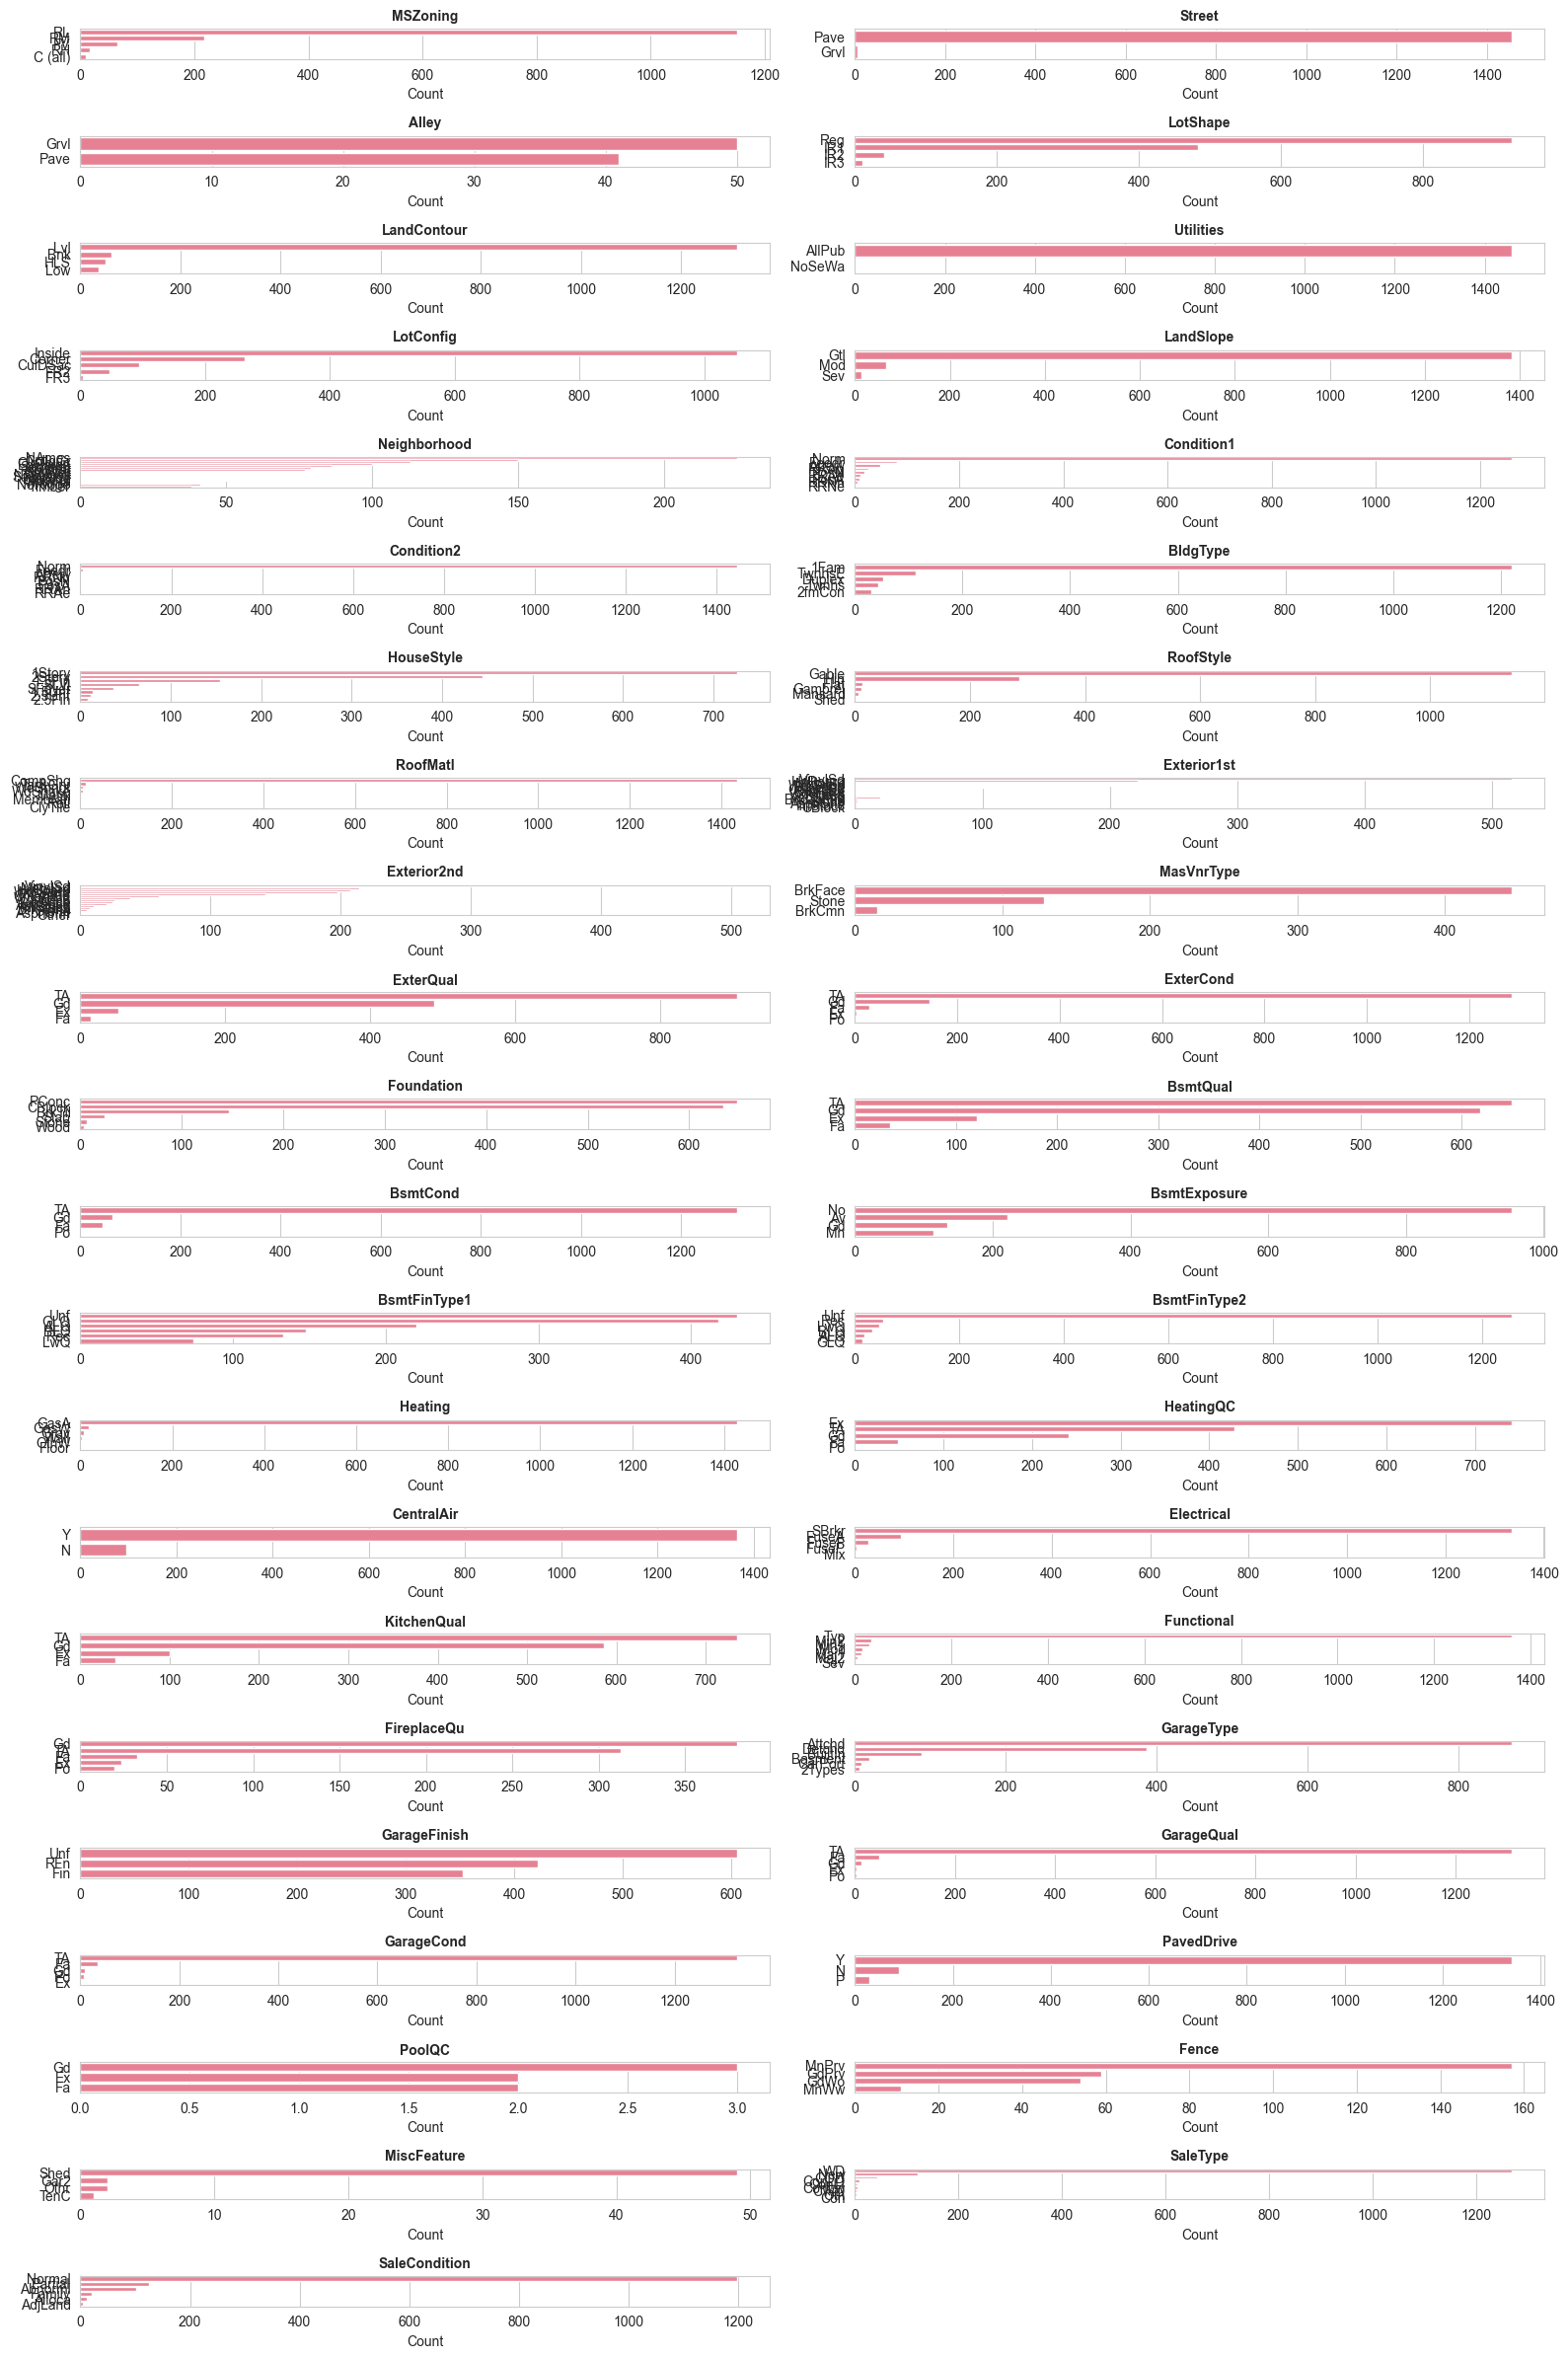


Category Distribution Analysis:
MSZoning             Categories:  5, Dominant:  78.8%, Rare (<10):  0
Street               Categories:  2, Dominant:  99.6%, Rare (<10):  1
Alley                Categories:  2, Dominant:   3.4%, Rare (<10):  0
LotShape             Categories:  4, Dominant:  63.4%, Rare (<10):  0
LandContour          Categories:  4, Dominant:  89.8%, Rare (<10):  0
Utilities            Categories:  2, Dominant:  99.9%, Rare (<10):  1
LotConfig            Categories:  5, Dominant:  72.1%, Rare (<10):  1
LandSlope            Categories:  3, Dominant:  94.7%, Rare (<10):  0
Neighborhood         Categories: 25, Dominant:  15.4%, Rare (<10):  2
Condition1           Categories:  9, Dominant:  86.3%, Rare (<10):  3
Condition2           Categories:  8, Dominant:  99.0%, Rare (<10):  7
BldgType             Categories:  5, Dominant:  83.6%, Rare (<10):  0
HouseStyle           Categories:  8, Dominant:  49.7%, Rare (<10):  1
RoofStyle            Categories:  6, Dominant:  78.2%, Ra

In [14]:
# Helper function to plot categorical distributions
def plot_categorical_distributions(df, cat_cols, n_cols=2, figsize=(15, 20)):
    """Plot bar charts for categorical features"""
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(cat_cols):
        if idx < len(axes) and col in df.columns:
            value_counts = df[col].value_counts().head(15)  # Top 15 categories
            sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[idx])
            axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
            axes[idx].set_xlabel('Count')
            axes[idx].set_ylabel('')
    
    # Hide extra subplots
    for idx in range(len(cat_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Select key categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

plot_categorical_distributions(df, categorical_cols, n_cols=2, figsize=(16, 24))

# Analyze category distribution
print("\nCategory Distribution Analysis:")
print("=" * 60)
for col in categorical_cols:
    if col in df.columns:
        value_counts = df[col].value_counts()
        n_categories = len(value_counts)
        dominant_pct = (value_counts.iloc[0] / len(df)) * 100
        rare_categories = (value_counts < 10).sum()
        print(f"{col:<20} Categories: {n_categories:>2}, Dominant: {dominant_pct:>5.1f}%, Rare (<10): {rare_categories:>2}")


### 📊 How to Analyze These Plots:

**Identifying Dominant vs Rare Categories:**
- **Dominant category**: One category with >50% of observations (e.g., CentralAir='Y')
  - Low predictive power if too dominant
  - Consider binary encoding or removal
- **Rare categories**: Categories with <10 observations
  - Can cause overfitting
  - Merge into "Other" category

**Category Merging Strategy:**
- **Low frequency categories**: Combine categories with <5% frequency into "Other"
- **Similar categories**: Merge semantically similar categories (e.g., different roof materials)
- **Ordinal encoding**: If categories have natural order (e.g., quality ratings), use ordinal encoding

**Low Variation (Poor Predictors):**
- **High dominance (>90%)**: Feature has little variation, minimal predictive power
- **Low cardinality with imbalance**: Few categories, one dominates → consider removal
- **Action**: Calculate feature importance or correlation to confirm before removal


---

# SECTION 5 — NUMERIC FEATURES VS SALEPRICE

## 9. Correlation Heatmap (Top 20 Numeric Features)


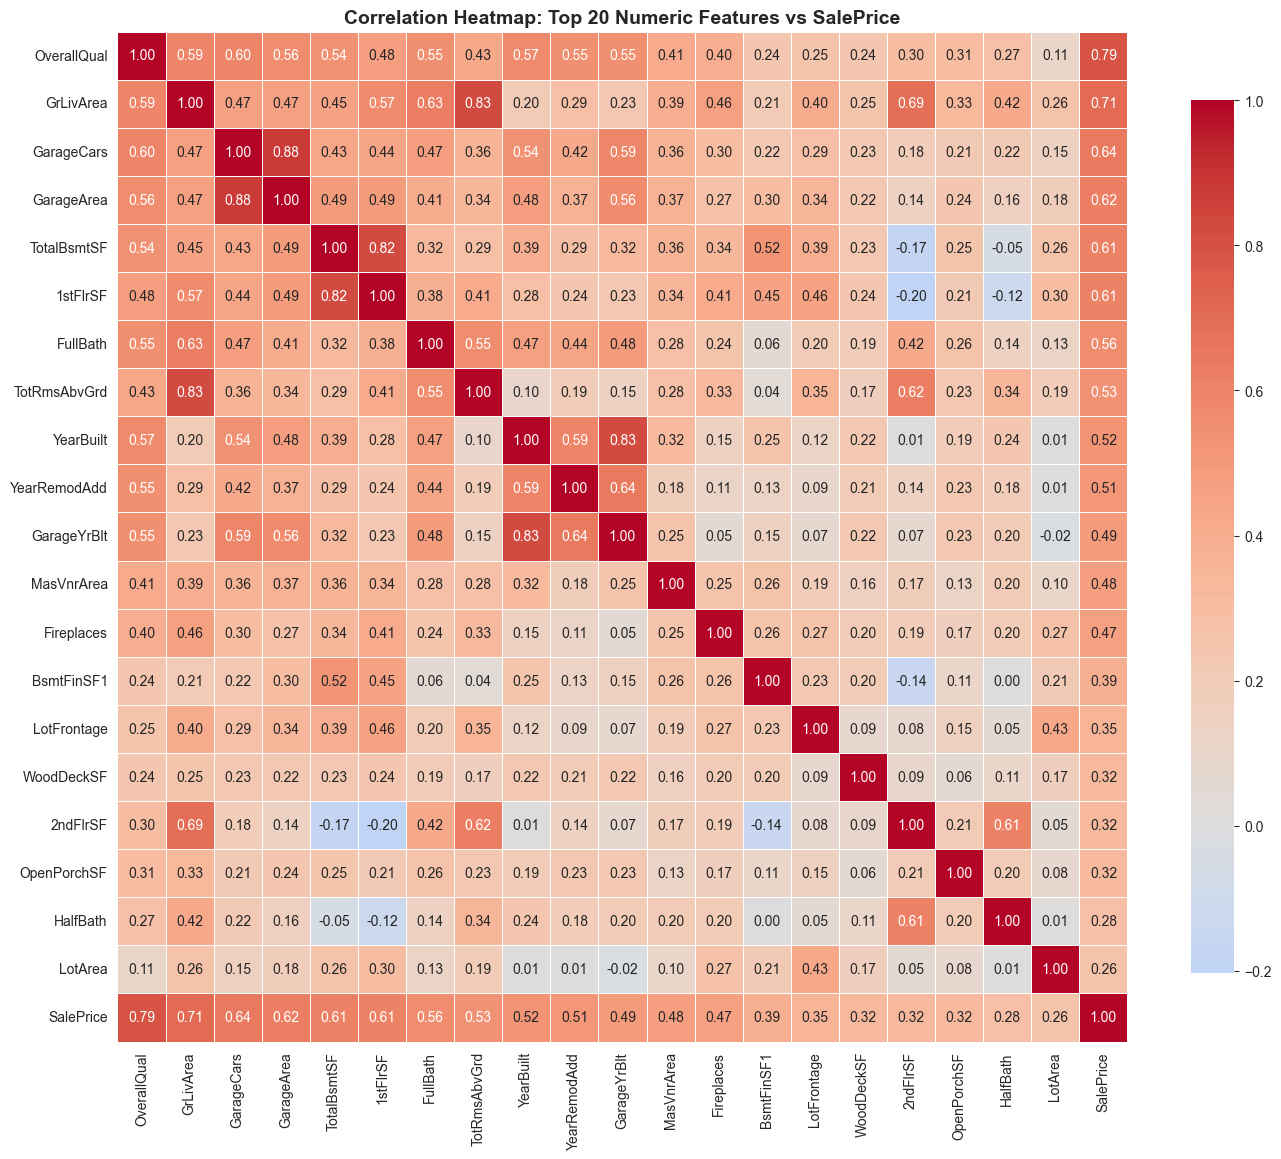


Top 20 Features Correlated with SalePrice:
OverallQual               Correlation:  0.791
GrLivArea                 Correlation:  0.709
GarageCars                Correlation:  0.640
GarageArea                Correlation:  0.623
TotalBsmtSF               Correlation:  0.614
1stFlrSF                  Correlation:  0.606
FullBath                  Correlation:  0.561
TotRmsAbvGrd              Correlation:  0.534
YearBuilt                 Correlation:  0.523
YearRemodAdd              Correlation:  0.507
GarageYrBlt               Correlation:  0.486
MasVnrArea                Correlation:  0.477
Fireplaces                Correlation:  0.467
BsmtFinSF1                Correlation:  0.386
LotFrontage               Correlation:  0.352
WoodDeckSF                Correlation:  0.324
2ndFlrSF                  Correlation:  0.319
OpenPorchSF               Correlation:  0.316
HalfBath                  Correlation:  0.284
LotArea                   Correlation:  0.264


In [21]:
# Calculate correlation with SalePrice
numeric_cols_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude Id, LogSalePrice, and SalePrice (we'll add SalePrice separately)
numeric_cols_for_corr = [col for col in numeric_cols_for_corr if col not in ['Id', 'LogSalePrice', 'SalePrice']]

# Calculate correlation matrix and extract SalePrice column as Series
corr_matrix_full = df[numeric_cols_for_corr + ['SalePrice']].corr()
correlations = corr_matrix_full['SalePrice'].sort_values(ascending=False)
top_20_corr = correlations.head(21).drop('SalePrice')  # Top 20 excluding SalePrice itself

# Create correlation matrix for top 20 features
corr_matrix = df[top_20_corr.index.tolist() + ['SalePrice']].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Heatmap: Top 20 Numeric Features vs SalePrice', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Print top correlations
print("\nTop 20 Features Correlated with SalePrice:")
print("=" * 60)
for feature, corr in top_20_corr.items():
    print(f"{feature:<25} Correlation: {corr:>6.3f}")


### 📊 How to Analyze This Plot:

**Interpreting Strong Predictors:**
- **High positive correlation (>0.5)**: Strong positive relationship with SalePrice
  - Examples: OverallQual, GrLivArea, GarageCars
  - These are key features for prediction
- **High negative correlation (<-0.3)**: Strong negative relationship
  - Less common, but indicates inverse relationship

**Detecting Multicollinearity:**
- **High feature-to-feature correlation (>0.8)**: Features are highly correlated
  - Example: TotalBsmtSF vs 1stFlrSF (often very similar)
  - GarageCars vs GarageArea (related garage features)
- **Problem**: Multicollinearity can cause:
  - Unstable coefficients in linear models
  - Redundant information
  - Overfitting risk

**Features That Shouldn't Exist Together:**
- **TotalBsmtSF & 1stFlrSF**: Very similar, use one or create ratio
- **GarageCars & GarageArea**: Redundant, choose one or combine
- **YearBuilt & YearRemodAdd**: Consider using age instead
- **Action**: Remove one, create interaction terms, or use dimensionality reduction


## 10. Scatterplots of Top Predictors vs SalePrice


In [ ]:
# Select top predictors for scatterplots
top_predictors = ['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'OverallQual']

# Create scatterplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, feature in enumerate(top_predictors):
    if feature in df.columns:
        # For OverallQual, use jitter for better visualization
        if feature == 'OverallQual':
            # Add small random jitter
            jitter = np.random.normal(0, 0.1, len(df))
            axes[idx].scatter(df[feature] + jitter, df['SalePrice'], alpha=0.5, s=20)
        else:
            axes[idx].scatter(df[feature], df['SalePrice'], alpha=0.5, s=20)
        
        # Add trend line
        z = np.polyfit(df[feature].dropna(), df.loc[df[feature].notna(), 'SalePrice'], 1)
        p = np.poly1d(z)
        axes[idx].plot(df[feature].sort_values(), p(df[feature].sort_values()), 
                      "r--", alpha=0.8, linewidth=2, label='Trend')
        
        axes[idx].set_xlabel(feature, fontsize=11)
        axes[idx].set_ylabel('Sale Price ($)', fontsize=11)
        axes[idx].set_title(f'{feature} vs SalePrice', fontsize=12, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

# Hide the last subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()

# Calculate correlation for each
print("\nCorrelation with SalePrice:")
print("=" * 40)
for feature in top_predictors:
    if feature in df.columns:
        corr = df[feature].corr(df['SalePrice'])
        print(f"{feature:<20} {corr:>6.3f}")


### 📊 How to Analyze These Plots:

**Detecting Linear vs Nonlinear Relationships:**
- **Linear relationship**: Points follow a straight line (trend line fits well)
  - Good for linear regression
  - Examples: GrLivArea, TotalBsmtSF show strong linear patterns
- **Nonlinear relationship**: Curved pattern, trend line doesn't fit well
  - Requires polynomial features or tree-based models
  - May need transformation

**Heteroscedasticity (Unequal Variance):**
- **Fan shape**: Variance increases with feature value (wider spread at high values)
  - Violates linear regression assumptions
  - Solution: Log transform target or feature
- **Constant variance**: Spread is similar across all values (ideal)

**Leverage Points/Outliers:**
- **Points far from trend**: May be outliers or influential observations
  - High leverage: Extreme X values
  - High influence: Both extreme X and Y values
- **Action**: Investigate these points, consider removal or robust methods

**Saturation Effects:**
- **Diminishing returns**: Value doesn't increase proportionally after certain point
  - Example: Very large houses may not command proportionally higher prices
  - Solution: Create capped features or use nonlinear models


---

# SECTION 6 — CATEGORICAL FEATURES VS SALEPRICE

## 11. Boxplots of SalePrice Grouped by Key Categorical Variables


In [ ]:
# Select key categorical variables
key_cat_vars = ['Neighborhood', 'HouseStyle', 'BldgType', 'ExterQual', 'KitchenQual', 'GarageQual']

# Create boxplots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, cat_var in enumerate(key_cat_vars):
    if cat_var in df.columns:
        # Get top categories by count (for Neighborhood, show top 10)
        if cat_var == 'Neighborhood':
            top_cats = df[cat_var].value_counts().head(10).index
            data_to_plot = df[df[cat_var].isin(top_cats)]
        else:
            data_to_plot = df
        
        # Create boxplot
        order = data_to_plot.groupby(cat_var)['SalePrice'].median().sort_values(ascending=False).index
        sns.boxplot(data=data_to_plot, x=cat_var, y='SalePrice', order=order, ax=axes[idx])
        axes[idx].set_title(f'SalePrice by {cat_var}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(cat_var, fontsize=10)
        axes[idx].set_ylabel('Sale Price ($)', fontsize=10)
        axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate median prices by category
print("\nMedian SalePrice by Category:")
print("=" * 60)
for cat_var in key_cat_vars:
    if cat_var in df.columns:
        if cat_var == 'Neighborhood':
            medians = df.groupby(cat_var)['SalePrice'].median().sort_values(ascending=False).head(10)
        else:
            medians = df.groupby(cat_var)['SalePrice'].median().sort_values(ascending=False)
        print(f"\n{cat_var}:")
        for cat, median_price in medians.items():
            print(f"  {str(cat):<20} ${median_price:>10,.0f}")


### 📊 How to Analyze These Plots:

**Comparing Median Prices:**
- **Box height**: Shows price range within each category
- **Median line**: Middle line in box shows median price
- **Compare medians**: Categories with higher medians are more valuable
  - Example: ExterQual='Ex' should have higher median than 'TA'

**Recognizing Category Ordering:**
- **Ordinal variables**: Quality ratings (Ex > Gd > TA > Fa > Po) should show clear ordering
  - Use ordinal encoding (1, 2, 3, 4, 5) instead of one-hot
- **Nominal variables**: No natural order (e.g., Neighborhood)
  - Use one-hot encoding or target encoding

**Detecting Strong Predictive Power:**
- **Wide spread between categories**: Large difference in medians indicates strong predictor
- **Consistent ordering**: Clear hierarchy suggests ordinal relationship
- **Low within-category variance**: Tight boxes indicate category is good predictor
- **Action**: Features with large median differences are high-priority for modeling


---

# SECTION 7 — MULTIVARIATE & ENGINEERED FEATURE EXPLORATION

## 12. Pairplot of Top Numeric Features


In [ ]:
# Select top features for pairplot
pairplot_features = ['SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'GarageCars', 'YearBuilt']

# Create pairplot (sample for performance)
sample_size = min(500, len(df))
df_sample = df[pairplot_features].sample(n=sample_size, random_state=42)

g = sns.pairplot(df_sample, diag_kind='kde', plot_kws={'alpha': 0.6, 's': 20})
g.fig.suptitle('Pairplot of Top Numeric Features', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print(f"\nPairplot created with {sample_size} samples for performance.")


### 📊 How to Analyze This Plot:

**Observing Interaction Patterns:**
- **Off-diagonal plots**: Show relationships between pairs of features
  - Look for nonlinear patterns, clusters, or interactions
- **Diagonal plots**: Show distributions of individual features

**Clustering Between High-Value Properties:**
- **Clusters in scatter plots**: Groups of points may indicate property types
  - High OverallQual + High GrLivArea = luxury properties
  - Low YearBuilt + High SalePrice = renovated historic homes
- **Action**: Consider creating interaction features (e.g., OverallQual × GrLivArea)

**Feature Interactions:**
- **Conditional relationships**: Relationship changes based on another feature
  - Example: GarageArea may matter more for newer homes
- **Create interaction terms**: Multiply or combine features that show interactions


## 13. Scatterplot: TotalSF vs SalePrice


In [ ]:
# Create TotalSF feature
df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'].fillna(0) + df['TotalBsmtSF'].fillna(0)

# Create scatterplot
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(df['TotalSF'], df['SalePrice'], alpha=0.5, s=30)

# Add trend line
z = np.polyfit(df['TotalSF'].dropna(), df.loc[df['TotalSF'].notna(), 'SalePrice'], 1)
p = np.poly1d(z)
ax.plot(df['TotalSF'].sort_values(), p(df['TotalSF'].sort_values()), 
        "r--", alpha=0.8, linewidth=2, label='Trend Line')

ax.set_xlabel('Total Square Feet (1stFlr + 2ndFlr + Basement)', fontsize=12)
ax.set_ylabel('Sale Price ($)', fontsize=12)
ax.set_title('TotalSF vs SalePrice', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate correlation
corr_total = df['TotalSF'].corr(df['SalePrice'])
corr_grliv = df['GrLivArea'].corr(df['SalePrice'])
print(f"\nCorrelation Analysis:")
print(f"TotalSF vs SalePrice: {corr_total:.3f}")
print(f"GrLivArea vs SalePrice: {corr_grliv:.3f}")
print(f"\nTotalSF includes basement, which may improve predictive power.")


### 📊 How to Analyze This Plot:

**Why TotalSF is More Predictive:**
- **Comprehensive measure**: Combines all living space (above and below grade)
  - 1stFlrSF + 2ndFlrSF + TotalBsmtSF captures total usable space
  - More complete than individual floor areas
- **Stronger correlation**: Should show higher correlation with SalePrice than individual components
- **Reduces multicollinearity**: Single feature instead of multiple correlated features

**Benefits of Engineered Features:**
- **Feature reduction**: Fewer features, less multicollinearity
- **Better interpretability**: TotalSF is intuitive
- **Improved model performance**: Often leads to better predictions

**Other Engineered Features to Consider:**
- **Age**: YearSold - YearBuilt
- **RemodelAge**: YearSold - YearRemodAdd
- **TotalBathrooms**: FullBath + 0.5*HalfBath + BsmtFullBath + 0.5*BsmtHalfBath
- **SF per Room**: TotalSF / TotRmsAbvGrd


## 14. Heatmap of Correlations Before and After Engineered Features


In [ ]:
# Create additional engineered features
df['Age'] = df['YrSold'] - df['YearBuilt']
df['RemodelAge'] = df['YrSold'] - df['YearRemodAdd']
df['TotalBathrooms'] = (df['FullBath'] + 0.5 * df['HalfBath'] + 
                        df['BsmtFullBath'].fillna(0) + 0.5 * df['BsmtHalfBath'].fillna(0))

# Select key features for comparison
original_features = ['GrLivArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'FullBath', 'HalfBath']
engineered_features = ['TotalSF', 'Age', 'TotalBathrooms']

# Create correlation matrices
original_corr = df[original_features + ['SalePrice']].corr()
engineered_corr = df[engineered_features + ['SalePrice']].corr()

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Original features
sns.heatmap(original_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title('Correlation: Original Features', fontsize=12, fontweight='bold')

# Engineered features
sns.heatmap(engineered_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title('Correlation: Engineered Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Compare correlations with SalePrice
print("\nCorrelation with SalePrice Comparison:")
print("=" * 60)
print("\nOriginal Features:")
for feat in original_features:
    corr = df[feat].corr(df['SalePrice'])
    print(f"  {feat:<20} {corr:>6.3f}")
print("\nEngineered Features:")
for feat in engineered_features:
    corr = df[feat].corr(df['SalePrice'])
    print(f"  {feat:<20} {corr:>6.3f}")


### 📊 How to Analyze This Plot:

**How Engineered Features Clarify Relationships:**
- **Reduced multicollinearity**: Engineered features combine correlated variables
  - TotalSF replaces multiple floor area features
  - TotalBathrooms combines multiple bathroom features
- **Stronger predictive power**: Engineered features often have higher correlation with target
  - TotalSF should correlate better than individual floor areas

**Strengthening Predictive Relationships:**
- **Age features**: Age and RemodelAge capture time-based effects
  - Negative correlation expected (older = lower price, unless historic/renovated)
- **Combined features**: Aggregate related information into single, more informative features

**Model Benefits:**
- **Fewer features**: Reduces dimensionality, prevents overfitting
- **Better interpretability**: Easier to understand model decisions
- **Improved performance**: Often leads to better cross-validation scores


---

# SECTION 8 — TEMPORAL ANALYSIS

## 15. SalePrice vs YrSold Scatterplot


In [ ]:
# Create scatterplot of SalePrice vs YrSold
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['YrSold'], df['SalePrice'], alpha=0.5, s=30)

# Add trend line
z = np.polyfit(df['YrSold'], df['SalePrice'], 1)
p = np.poly1d(z)
ax.plot(df['YrSold'].sort_values(), p(df['YrSold'].sort_values()), 
        "r--", alpha=0.8, linewidth=2, label='Trend Line')

ax.set_xlabel('Year Sold', fontsize=12)
ax.set_ylabel('Sale Price ($)', fontsize=12)
ax.set_title('SalePrice vs Year Sold', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate average price by year
avg_by_year = df.groupby('YrSold')['SalePrice'].mean()
print("\nAverage SalePrice by Year:")
print("=" * 40)
for year, avg_price in avg_by_year.items():
    print(f"{year}: ${avg_price:,.2f}")


## 16. Monthly Sale Count (Barplot of MoSold)


In [ ]:
# Create barplot of monthly sales
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Monthly sale count
monthly_counts = df['MoSold'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_counts.index = [month_names[i-1] for i in monthly_counts.index]

sns.barplot(x=monthly_counts.index, y=monthly_counts.values, ax=axes[0])
axes[0].set_title('Number of Sales by Month', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Month', fontsize=11)
axes[0].set_ylabel('Number of Sales', fontsize=11)
axes[0].tick_params(axis='x', rotation=45)

# Average price by month
monthly_avg_price = df.groupby('MoSold')['SalePrice'].mean()
monthly_avg_price.index = [month_names[i-1] for i in monthly_avg_price.index]

sns.barplot(x=monthly_avg_price.index, y=monthly_avg_price.values, ax=axes[1])
axes[1].set_title('Average SalePrice by Month', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Month', fontsize=11)
axes[1].set_ylabel('Average Sale Price ($)', fontsize=11)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nMonthly Sales Statistics:")
print("=" * 50)
for month, count in monthly_counts.items():
    avg_price = monthly_avg_price[month]
    print(f"{month:<5} Sales: {count:>4}, Avg Price: ${avg_price:>10,.0f}")


### 📊 How to Analyze These Plots:

**Seasonality Patterns:**
- **Peak selling months**: Spring/summer typically have more sales (May-July)
  - Weather is better for house hunting
  - Families prefer to move before school year
- **Low selling months**: Winter months (Dec-Feb) typically have fewer sales

**Market Trends:**
- **Year-over-year changes**: Look for trends in average prices across years
  - Rising trend: Market appreciation
  - Falling trend: Market decline (e.g., 2008 financial crisis)
- **Price by year**: YrSold may show market conditions

**Predictive Value:**
- **Seasonal features**: MoSold may have predictive power if seasonality exists
  - Create cyclical encoding (sin/cos) for months
  - Or create binary features (spring, summer, fall, winter)
- **Year features**: YrSold may capture market conditions
  - Consider creating market condition features
  - Or use as interaction with other features


---

# SECTION 9 — SUMMARY OF INSIGHTS


In [ ]:
# Generate summary of insights
print("=" * 80)
print("COMPREHENSIVE EDA SUMMARY - KEY INSIGHTS")
print("=" * 80)

# Top predictors
print("\n1. TOP PREDICTORS (Highest Correlation with SalePrice):")
print("-" * 80)
numeric_cols_for_corr = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude Id, LogSalePrice, and SalePrice (we'll add SalePrice separately)
numeric_cols_for_corr = [col for col in numeric_cols_for_corr if col not in ['Id', 'LogSalePrice', 'SalePrice']]
# Calculate correlation matrix and extract SalePrice column as Series
corr_matrix_full = df[numeric_cols_for_corr + ['SalePrice']].corr()
correlations = corr_matrix_full['SalePrice'].sort_values(ascending=False)
top_10 = correlations.head(11).drop('SalePrice')
for i, (feat, corr) in enumerate(top_10.items(), 1):
    print(f"   {i:2d}. {feat:<25} Correlation: {corr:>6.3f}")

# Variables requiring transformation
print("\n2. VARIABLES REQUIRING TRANSFORMATION (High Skewness > 1):")
print("-" * 80)
high_skew = []
for col in numeric_cols_for_corr:
    if col in df.columns:
        skew_val = df[col].skew()
        if abs(skew_val) > 1:
            high_skew.append((col, skew_val))
high_skew.sort(key=lambda x: abs(x[1]), reverse=True)
for col, skew_val in high_skew[:10]:
    print(f"   - {col:<25} Skewness: {skew_val:>7.2f} (Log transform recommended)")

# Variables needing imputation
print("\n3. VARIABLES NEEDING IMPUTATION (Missing Values > 5%):")
print("-" * 80)
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100
high_missing = missing_percent[missing_percent > 5].sort_values(ascending=False)
for feat, pct in high_missing.items():
    dtype = 'Categorical' if df[feat].dtype == 'object' else 'Numerical'
    strategy = 'Mode/None category' if dtype == 'Categorical' else 'Median'
    print(f"   - {feat:<25} Missing: {pct:>5.1f}% ({dtype} - Use {strategy})")

# Candidate engineered features
print("\n4. CANDIDATE ENGINEERED FEATURES:")
print("-" * 80)
engineered_candidates = [
    "TotalSF (1stFlrSF + 2ndFlrSF + TotalBsmtSF) - Created",
    "Age (YrSold - YearBuilt) - Created",
    "RemodelAge (YrSold - YearRemodAdd) - Created",
    "TotalBathrooms (FullBath + 0.5*HalfBath + BsmtFullBath + 0.5*BsmtHalfBath) - Created",
    "SF_per_Room (TotalSF / TotRmsAbvGrd) - Recommended",
    "OverallQual × GrLivArea (Interaction) - Recommended",
    "HasPool (PoolArea > 0) - Recommended",
    "HasGarage (GarageArea > 0) - Recommended",
    "Has2ndFloor (2ndFlrSF > 0) - Recommended",
    "HasBasement (TotalBsmtSF > 0) - Recommended"
]
for feat in engineered_candidates:
    print(f"   - {feat}")

# Features likely to cause multicollinearity
print("\n5. FEATURES LIKELY TO CAUSE MULTICOLLINEARITY (Correlation > 0.8):")
print("-" * 80)
corr_matrix = df[numeric_cols_for_corr].corr()
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr_val in high_corr_pairs[:10]:
    print(f"   - {feat1:<20} vs {feat2:<20} Correlation: {corr_val:>6.3f}")

# Target variable insights
print("\n6. TARGET VARIABLE INSIGHTS:")
print("-" * 80)
print(f"   - Original skewness: {df['SalePrice'].skew():.2f} (Right-skewed)")
print(f"   - Log-transformed skewness: {df['LogSalePrice'].skew():.2f} (Much improved)")
print(f"   - Mean: ${df['SalePrice'].mean():,.2f}")
print(f"   - Median: ${df['SalePrice'].median():,.2f}")
print(f"   - Recommendation: Use LogSalePrice as target for linear models")

print("\n" + "=" * 80)
print("END OF EDA SUMMARY")
print("=" * 80)
